<a href="https://colab.research.google.com/github/edgi-govdata-archiving/EEW-SOEP/blob/main/SOE_HazWaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAZWASTE
This notebook will be used to measure indicators for EDGI/EEW's "state of environmental protection" report ahead of Trump's second administration.

It will pull hazardous waste data from EPA's Risk Screening Environmental Indicators (RSEI; computes hazard and risk scores using the Toxic Releases Inventory - TRI) and the Superfund Enterprise Management System (SEMS):


*  RSEI - uses reported releases of toxics from TRI, along with toxicity information, to estimate chemical hazards (pounds released * toxicity) and a risk score (hazard * population likely exposed).
*  SEMS - lists reported chemical contaminants for each currently and formerly listed Superfund site. More about Superfund here: https://www.epa.gov/superfund/what-superfund



In [ ]:
# RSEI
# Access: https://gaftp.epa.gov/rsei/Current_Version/V2312_RY2022/Public_Release_Data/
# Data dictionary: https://www.epa.gov/rsei/rsei-data-dictionary-elements-data

# Get the RSEI data
# Download from https://gaftp.epa.gov/rsei/Current_Version/V2312_RY2022/Public_Release_Data/RSEIv2312_Public_Release_Data.zip
# and then upload to Colab manually
import zipfile
z = zipfile.ZipFile("/content/RSEIv2312_Public_Release_Data.zip") # May take some time to unzip
z.extractall("")

In [ ]:
# Load RSEI data into notebook
"""
RSEI data is separated into a few tables:
elements = this is where the hazard and risk scores are
submissions = the TRI submissions made by a facility. Each submission may include multiple releases.
releases = specific details about each release submitted
chemicals = details about the toxicity of each TRI chemical
Use the data dictionary to learn more about what each table contains:
https://www.epa.gov/rsei/rsei-data-dictionary-elements-data
"""
import pandas
rsei = pandas.read_csv("/content/elements_data_rsei_v2312.csv",
                       usecols=["ReleaseNumber", "PoundsPT", "ScoreCategory",
                                "Score", "Population", "Hazard", "NCScore", "CScore"]) # Load in the CSV file
# Notice that we are not loading in all columns in the elements file, since it is a large one
# In the future, we may want to load in risk scores for specific age ranges. See data dictionary.
releases = pandas.read_csv("/content/releases_data_rsei_v2312.csv") # Load in the CSV file
submissions = pandas.read_csv("/content/submissions_data_rsei_v2312.csv") # Load in the CSV file
facs = pandas.read_csv("/content/facility_data_rsei_v2312.csv") # Load in the CSV File
chem = pandas.read_csv("/content/chemical_data_rsei_v2312.csv") # Load in the CSV file

rsei

<ipython-input-3-b36b9e210e09>:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  releases = pandas.read_csv("/content/releases_data_rsei_v2312.csv") # Load in the CSV file
<ipython-input-3-b36b9e210e09>:18: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pandas.read_csv("/content/submissions_data_rsei_v2312.csv") # Load in the CSV file
<ipython-input-3-b36b9e210e09>:19: DtypeWarning: Columns (18,27,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  facs = pandas.read_csv("/content/facility_data_rsei_v2312.csv") # Load in the CSV File


,ReleaseNumber,PoundsPT,ScoreCategory,Score,Population,NCScore,CScore,Hazard
0,243100,3355.0000,36,0.0,0.000000e+00,0.0,0.0,2348.5
1,243101,3950.0000,36,0.0,0.000000e+00,0.0,0.0,0.0
2,243103,735.0000,36,0.0,0.000000e+00,0.0,0.0,25725.0
3,243114,135284.0000,36,0.0,0.000000e+00,0.0,0.0,202926000.0
4,243115,7121.0000,36,0.0,0.000000e+00,0.0,0.0,10681500.0
...,...,...,...,...,...,...,...,...
10928315,9320950,10.7820,37,0.0,0.000000e+00,0.0,0.0,0.0
10928316,9320951,5.2130,7,0.0,1.660438e+06,0.0,0.0,0.0
10928317,9320951,2.6065,57,0.0,1.528230e+04,0.0,0.0,0.0
10928318,9320951,2.6065,107,0.0,8.043300e+02,0.0,0.0,0.0


In [ ]:
# Filter RSEI to submissions since 2001
# For our purposes, 2001 (start of Bush's first administration) is ok for a long-term analysis
submissions = submissions[submissions['SubmissionYear']>=2001][["SubmissionNumber", "ChemicalNumber", "SubmissionYear", "FacilityID"]]
# Below, we lookup each chemical in the chemicals table so that information is directly available in the submissions table
submissions = pandas.merge(submissions, chem[["ChemicalNumber", "Chemical"]], on="ChemicalNumber")
# Get facility IDs (FRS)
submissions = pandas.merge(submissions, facs[["FacilityID", 'FRSID']], on="FacilityID")
# Filter releases to land
# There are many categories that could fit here...
# We'll focus on those in the 400-500 range, underground injections and various landfilling
# Other categories include offsite transfers
# See the media_data_rsei CSV file
releases = releases[(releases["Media"] >= 400) & (releases["Media"] < 600)]
# We merge the releases and submissions so that all the releases will have chemical names listed directly
compilation = pandas.merge(releases[["ReleaseNumber", "SubmissionNumber", "Media", "PoundsReleased"]], submissions, on="SubmissionNumber") # how="left"
# Finally, we add the releases information to the elements table, so that each "element"/risk score/hazard has its chemical name associated with it
final = pandas.merge(compilation[["ReleaseNumber", "SubmissionYear", "Chemical", "Media", "FacilityID", "FRSID"]], rsei, on="ReleaseNumber")
final

,ReleaseNumber,SubmissionYear,Chemical,Media,FacilityID,FRSID,PoundsPT,ScoreCategory,Score,Population,NCScore,CScore,Hazard
0,3295152,2001,Polychlorinated biphenyls,540,60409CDRCY138TH,1.100116e+11,4.400000e+00,36,0.0,0.0,0.0,0.0,8.800000e+06
1,3295154,2001,Polychlorinated biphenyls,560,60409CDRCY138TH,1.100116e+11,2.200000e+00,36,0.0,0.0,0.0,0.0,4.400000e+06
2,3295155,2001,Polychlorinated biphenyls,590,60409CDRCY138TH,1.100116e+11,5.700000e+00,36,0.0,0.0,0.0,0.0,1.140000e+07
3,3295158,2001,Phenol,590,60409CDRCY138TH,1.100116e+11,6.132000e+03,36,0.0,0.0,0.0,0.0,2.023560e+04
4,3295160,2001,Phenol,560,60409CDRCY138TH,1.100116e+11,1.480000e+02,36,0.0,0.0,0.0,0.0,4.884000e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244345,9238174,2022,Lead,560,36081SNDRSHENDE,1.100708e+11,1.170169e+06,36,0.0,0.0,0.0,0.0,2.106305e+10
244346,9238207,2022,Dioxin and dioxin-like compounds (Manufacturin...,540,75570NWBSTHWY82,1.100127e+11,6.174000e-06,36,0.0,0.0,0.0,0.0,9.492525e+01
244347,9238242,2022,Lead,540,7860WFDRLC1341H,1.100065e+11,4.200000e+02,36,0.0,0.0,0.0,0.0,7.560000e+06
244348,9238413,2022,Lead,532,5975WSLVYS11913,NaN,3.000000e+04,36,0.0,0.0,0.0,0.0,5.400000e+08


In [ ]:
# Indicators to measure and visualize, 2001-present
# Most commonly reported substances and total amounts of those reported + hazard score
final.groupby(by="Chemical")[["ReleaseNumber", "FacilityID", "PoundsPT", "Hazard"]].agg(
    {"ReleaseNumber":"nunique", "FacilityID":"nunique", "PoundsPT":"sum", "Hazard": "sum"}
    ).astype(int).sort_values(by="ReleaseNumber", ascending=False).head(50)

,ReleaseNumber,FacilityID,PoundsPT,Hazard
Chemical,,,,
Lead compounds,24715,2096,11899456024,214190208442291
Zinc compounds,14028,1078,12610177090,41613584398
Mercury compounds,13750,952,106421542,1064215428885
Manganese compounds,13702,874,3315729641,23541680452
Barium compounds (except for barium sulfate (CAS No. 7727-43-7)),12033,714,3895919176,19479595881
Lead,10573,1698,249910887,4498395966456
"Copper compounds (this category does not include copper phthalocyanine compounds that are substituted with only hydrogen, and/or chlorine, and/or bromine.)",10453,713,3953938589,5930907884093
"Chromium compounds (except for chromite ore mined in the Transvaal Region of South Africa and the unreacted ore component of the chromite ore processing residue (COPR). COPR is the solid waste remaining after aqueous extraction of oxidized chromite ore that has been combined with soda ash and kiln roasted at approximately 2,000 F.)",9491,703,697918069,78010416833176
Nickel compounds,9073,660,488641103,44466340460


<Axes: xlabel='SubmissionYear'>

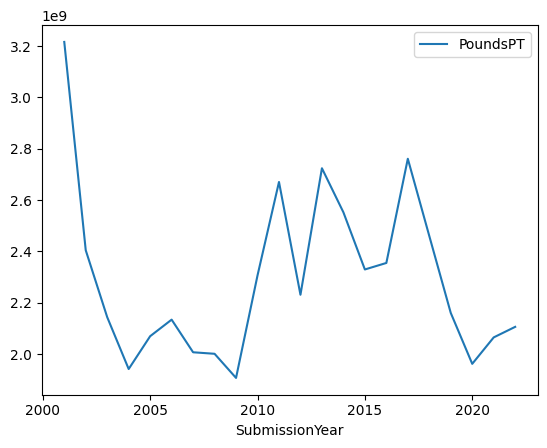

In [ ]:
# Total pounds of releases 2001-2022
final.groupby(by="SubmissionYear")[["PoundsPT"]].sum().astype(int).plot()

In [ ]:
# Total pounds of releases 2001-2022, for key pollutants (defined by high risk scores and/or commonly reported)
"""
Note: here we focus on HAZARD rather than RISK (SCORE) because RSEI does not model
risk for landfills.
'The current version of the RSEI model, however, does not provide risk-related modeling results
for these types of reported land releases. EPA is currently evaluating screening-level exposure
methodologies which might be used and incorporated into the RSEI model to assess risk-related
impacts pertaining to groundwater exposure from on- and off-site land releases and volatilization
from off-site land releases. For the time being, however, the RSEI model does provide the
capability for users to examine the quantities of releases (pounds) to land that are reported to the
TRI program, as well as viewing these releases from a hazard-based perspective.'
https://www.epa.gov/system/files/documents/2024-03/rsei-methodology-document-v2312-march2024.pdf
"""
final.groupby(by=["SubmissionYear", "Chemical"])[["Hazard"]].sum().astype(int).sort_values(by=[("Hazard")], ascending=False).head(50)

,,Hazard
SubmissionYear,Chemical,
2015,Arsenic compounds,655595637690000
2002,Arsenic compounds,595580035500000
2001,Arsenic compounds,536810664000000
2011,Arsenic compounds,522076334820000
2021,Arsenic compounds,484895450195010
2020,Arsenic compounds,467431850989035
2003,Arsenic compounds,428743898694345
2017,Arsenic compounds,411194864415000
2013,Arsenic compounds,377659976640000


In [ ]:
# Total number of facilities reporting each key pollutant over time
## Polychlorinated biphenyls, Lead compounds, Arsenic compounds
key_polls = ["Polychlorinated biphenyls ", "Lead compounds", "Arsenic compounds"]
keypollutants = final[final["Chemical"].isin(key_polls)] # Extra space in Polychlorinated biphenyls :(
keypollutants.groupby(by="Chemical")[["FacilityID"]].nunique()

,FacilityID
Chemical,
Arsenic compounds,293
Lead compounds,2096
Polychlorinated biphenyls,47


In [ ]:
# Percent change in the average of 2017, 18, 29, 20 (Trump) vs the average of other administrations e.g. 2013, 14, 15, 16 (Obama 2), for key pollutants
# ^ Be sure to acknowledge the drop offs in 2020 due to COVID
s = keypollutants.groupby(by="SubmissionYear")[["ReleaseNumber", "FacilityID", "PoundsPT", "Hazard"]].agg(
    {"ReleaseNumber":"nunique", "FacilityID":"nunique", "PoundsPT":"sum", "Hazard": "sum"}
    ).astype(int)
# Measure intensity here (releases/facility)
s["Intensity"] = s["ReleaseNumber"]/s["FacilityID"]
s

,ReleaseNumber,FacilityID,PoundsPT,Hazard,Intensity
SubmissionYear,,,,,
2001-01-01,1513,973,735315992,550667700996257,1.554985
2002-01-01,1492,975,756053508,604527803329747,1.530256
2003-01-01,1439,922,696681340,479737309599227,1.560738
2004-01-01,1452,945,523949736,185691110443833,1.536508
2005-01-01,1500,964,607235157,282865190074090,1.556017
2006-01-01,1451,931,557821663,177728440084009,1.558539
2007-01-01,1483,948,557108242,162866194355528,1.564346
2008-01-01,1475,945,532290872,136217935138067,1.560847
2009-01-01,1423,909,445965938,146448772315518,1.565457


In [ ]:
keypollutants["SubmissionYear"] = pandas.to_datetime(keypollutants["SubmissionYear"], format='%Y')
keypollutants.resample('4A', origin="start", label="left", closed='left', on='SubmissionYear')[["ReleaseNumber", "FacilityID", "PoundsPT", "Hazard"]].agg(
    {"ReleaseNumber":"nunique", "FacilityID":"nunique", "PoundsPT":"median", "Hazard": "median"}
    ).astype(int)

<ipython-input-10-65180a2b14ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keypollutants["SubmissionYear"] = pandas.to_datetime(keypollutants["SubmissionYear"], format='%Y')
<ipython-input-10-65180a2b14ac>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  keypollutants.resample('4A', origin="start", label="left", closed='left', on='SubmissionYear')[["ReleaseNumber", "FacilityID", "PoundsPT", "Hazard"]].agg(


,ReleaseNumber,FacilityID,PoundsPT,Hazard
SubmissionYear,,,,
2000-12-31,5896,1317,2100,58661100
2004-12-31,5909,1194,1674,46800000
2008-12-31,5648,1084,1591,43738360
2012-12-31,5526,1066,993,27503100
2016-12-31,4965,1000,772,20584800
2020-12-31,2285,874,585,17285400


In [ ]:
# Breakdown by chemicals with different health effects e.g. change in volume of substances known to be carcinogens (see chemicals table)
carcinogens = chem[chem['ToxicityCategory']=="Carcinogen"]
carcinogens = list(carcinogens["Chemical"].unique())
carcinogens = final[final["Chemical"].isin(carcinogens)]
carcinogens["SubmissionYear"] = pandas.to_datetime(carcinogens["SubmissionYear"], format='%Y')
carcinogens = carcinogens.resample('4A', origin="start", label="left", closed='left', on='SubmissionYear')[["ReleaseNumber", "FacilityID", "PoundsPT", "Hazard"]].agg(
    {"ReleaseNumber":"nunique", "FacilityID":"nunique", "PoundsPT":"median", "Hazard": "median"}
    ).astype(int)
#carcinogens.index = carcinogens.index.strftime('%Y')
carcinogens

<ipython-input-11-15d16cab65f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carcinogens["SubmissionYear"] = pandas.to_datetime(carcinogens["SubmissionYear"], format='%Y')
<ipython-input-11-15d16cab65f7>:6: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  carcinogens = carcinogens.resample('4A', origin="start", label="left", closed='left', on='SubmissionYear')[["ReleaseNumber", "FacilityID", "PoundsPT", "Hazard"]].agg(


,ReleaseNumber,FacilityID,PoundsPT,Hazard
SubmissionYear,,,,
2000-12-31,8801,1254,550,450000
2004-12-31,8278,1046,606,450000
2008-12-31,7743,945,574,384500
2012-12-31,7232,882,540,342000
2016-12-31,6353,775,396,270000
2020-12-31,2940,616,380,233200


In [ ]:
# Which facilities increased releases during the Trump administration?
final["SubmissionYear"] = pandas.to_datetime(final["SubmissionYear"], format='%Y')#.dt.strftime('%Y')

obama = final[(final["SubmissionYear"]>="2013") & (final["SubmissionYear"]<"2017")]
obama = obama.groupby(by=["FacilityID"])[["PoundsPT", "Hazard"]].sum().reset_index()

trump = final[(final["SubmissionYear"]>="2017") & (final["SubmissionYear"]<"2021")]
trump = trump.groupby(by=["FacilityID"])[["PoundsPT", "Hazard"]].sum().reset_index()

joined = pandas.merge(obama, trump, on="FacilityID", how="left", suffixes=["_obama", "_trump"])
joined["pounds diff"] = joined["PoundsPT_obama"] - joined["PoundsPT_trump"]
joined["hazards diff"] = joined["Hazard_obama"] - joined["Hazard_trump"]
joined.sort_values(by="pounds diff", ascending=False).head(50)

increases = joined[joined["hazards diff"]<0]
increases

,FacilityID,PoundsPT_obama,Hazard_obama,PoundsPT_trump,Hazard_trump,pounds diff,hazards diff
5,0073WLLDWSBARAM,1.691308e+06,2.143440e+08,9.847044e+06,5.292792e+09,-8.155736e+06,-5.078448e+09
8,00771BDLSPPBX27,6.248000e+03,5.623200e+08,7.353000e+03,6.617700e+08,-1.105000e+03,-9.945000e+07
10,00851HSSLVLIMET,4.142200e+02,9.576162e+05,5.614300e+02,3.565353e+06,-1.472100e+02,-2.607737e+06
18,01453SPCTR50FRA,1.000000e+00,3.300000e+00,7.000000e+00,2.310000e+01,-6.000000e+00,-1.980000e+01
20,01472HLLNGTOWNS,3.040000e+04,1.367000e+05,4.100000e+04,1.834100e+05,-1.060000e+04,-4.671000e+04
...,...,...,...,...,...,...,...
2680,99707FRTKN1FORA,4.804945e+07,1.589519e+12,7.064590e+07,3.992763e+12,-2.259644e+07,-2.403244e+12
2682,99737SRMYFRICHA,5.688450e+04,3.491700e+08,6.804270e+04,4.574361e+08,-1.115820e+04,-1.082661e+08
2683,99743HLYPW25MIL,4.000000e+00,4.000000e+04,6.700510e+04,2.352420e+07,-6.700110e+04,-2.348420e+07
2684,9974WSBLLC1RIVE,5.233860e+05,3.001002e+09,5.803770e+05,3.327906e+09,-5.699100e+04,-3.269033e+08


In [ ]:
# Which facilities/industries increased hazard while decreasing pounds - more toxic?
intense = joined[(joined["pounds diff"]>0) & (joined["hazards diff"]<0)]
intense = facs[facs["FacilityID"].isin(list(intense["FacilityID"].unique()))]
intense.groupby(by=["NAICS1"])[["FacilityID"]].nunique().sort_values(by="FacilityID",ascending=False)

,FacilityID
NAICS1,
221112.0,13
324110.0,13
327320.0,9
322110.0,4
212230.0,4
562212.0,3
562211.0,3
311613.0,3
321113.0,3


In [ ]:
# Where are the facilities reporting greater hazards?
increases = facs[facs["FacilityID"].isin(list(increases["FacilityID"].unique()))]
increases

,FacilityID,FacilityNumber,FRSID,Latitude,Longitude,GridCode,X,Y,LatLongSource,LLYear,...,FinalReach,FinalCOMID,ReachSource,DistanceToReach,HEM3ID,DistanceToHEM3,LLConfirmed,WaterReleases,ModeledReleases,ModChromReleases
6,46124SRMYCHOSPI,7,1.100105e+11,39.355600,-86.039100,14.0,1048.0,2295.0,FRS,2023,...,NaN,18461740.0,NaN,1552.469819,53866,31973.658360,False,NaN,True,NaN
8,89049TNPHTTNPAH,9,1.100138e+11,38.018990,-116.934590,14.0,-2229.0,2302.0,FRS,2023,...,NaN,19832642.0,NaN,1058.687947,23153,18144.392530,False,NaN,True,NaN
11,88220SDWST3MILE,12,1.100608e+11,32.375000,-103.791667,14.0,-899.0,1313.0,FRS,2023,...,NaN,NaN,NaN,NaN,93033,44182.445440,False,NaN,True,NaN
18,2951WFCBNN696MU,19,1.100122e+11,34.675387,-79.723658,14.0,1818.0,1749.0,FRS,2023,...,NaN,9166424.0,NaN,726.904835,93782,35161.312700,False,NaN,True,NaN
20,77705FDRLC543KA,21,1.100395e+11,29.964825,-94.079189,14.0,229.0,947.0,Manual,2012,...,NaN,1479327.0,NaN,3447.898919,12917,6213.855703,True,NaN,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63380,68008CRGLL650IN,63381,1.100598e+11,41.533970,-96.097900,14.0,-10.0,2542.0,FRS,2023,...,NaN,17215844.0,NaN,515.603958,94978,26429.781350,False,True,True,NaN
63381,32533MNSNT3000O,63382,1.100274e+11,30.596678,-87.251977,14.0,1032.0,1079.0,FRS,2023,...,3.140305e+12,448612.0,Outfall,69.917677,13899,15254.660480,False,True,True,NaN
63432,71635GRGPCPAPER,63433,1.100005e+11,33.139372,-91.965570,14.0,462.0,1391.0,FRS,2023,...,8.040202e+12,17915145.0,Outfall,19.766648,53919,58914.978680,False,True,True,NaN
63480,58075MNNDK7525R,63481,1.100224e+11,46.323539,-96.615920,14.0,-59.0,3201.0,FRS,2023,...,9.020104e+12,6668499.0,Outfall,430.198325,14914,65623.395030,False,True,True,NaN


In [ ]:
# Map
import geopandas
import folium

increases = geopandas.GeoDataFrame(
    increases, geometry=geopandas.points_from_xy(increases['Longitude'],
                                                 increases['Latitude'],
                                                 crs=4269))

m = folium.Map()

folium.GeoJson(
    increases
).add_to(m)

m

In [ ]:
# Which industries are these hazards increasing facilities a part of?
increases.groupby(by=['NAICS1'])[["FacilityID"]].nunique().sort_values(by="FacilityID",ascending=False)

,FacilityID
NAICS1,
327320.0,109
928110.0,79
221112.0,47
324110.0,35
321113.0,22
...,...
326122.0,1
326113.0,1
325992.0,1


In [ ]:
# Which specific toxics actually increased during the Trump administration?
## First, create year to year change for each chemical
final["SubmissionYear"] = pandas.to_datetime(final["SubmissionYear"], format='%Y')#.dt.strftime('%Y')
grouped = final.groupby(by=["SubmissionYear", "Chemical"])[["PoundsPT"]].sum().reset_index()

results = {}
for c in list(grouped["Chemical"].unique()):
  this_c = grouped[grouped["Chemical"]==c]
  this_c.set_index("SubmissionYear", inplace=True)
  result = this_c[["PoundsPT"]].join(this_c["PoundsPT"].pct_change(4, freq=pandas.DateOffset(years=1))*100, rsuffix="_4YearMovingChange")
  avg = this_c[["PoundsPT"]].rolling("1460D").mean() # Issues with leap years?
  result = result.join(avg, rsuffix="_4YearRollingAverage")
  """
  ## Now filter to where 2019 / 2020 are positive, representing increase 2016-2019, 2017-2020
  if ("2019" in result.index):
    if (result.at["2019", "PoundsPT_4YearMovingChange"]>0):
      results[c]["2019"] = result
  if ("2020" in result.index):
    if (result.at["2020", "PoundsPT_4YearMovingChange"]>0):
      results[c]["2020"] = result
  """
  ## Now filter to where the 4 year rolling average of (2013, 2014, 2015, 2016) < (2017, 2018, 2019, 2020)
  if ("2020" in result.index) & ("2016" in result.index):
    if (result.at["2020", "PoundsPT_4YearRollingAverage"] > result.at["2016", "PoundsPT_4YearRollingAverage"]):
      results[c] = result
results.keys()

<ipython-input-17-3b0a091a832f>:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (result.at["2020", "PoundsPT_4YearRollingAverage"] > result.at["2016", "PoundsPT_4YearRollingAverage"]):
<ipython-input-17-3b0a091a832f>:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (result.at["2020", "PoundsPT_4YearRollingAverage"] > result.at["2016", "PoundsPT_4YearRollingAverage"]):
<ipython-input-17-3b0a091a832f>:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (result.at["2020", "PoundsPT_4YearRollingAverage"] > result.at["2016", "PoundsPT_4YearRollingAverage"]):
<

dict_keys(['1,1,1,2-Tetrachloroethane', '1,2,4-Trichlorobenzene', '1,2-Dichlorobenzene (o-Dichlorobenzene)', '1,3-Butadiene', '1,4-Dichloro-2-butene', '2,4-Dimethylphenol', '2,4-Dinitrophenol', "4,4'-Isopropylidenediphenol", 'Acetamide', 'Acetonitrile', 'Acetophenone', 'Acrylamide', 'Allyl alcohol', 'Ammonia (includes anhydrous ammonia and aqueous ammonia from water dissociable ammonium salts and other sources; 10 percent of total aqueous ammonia is reportable under this listing)', 'Aniline', 'Antimony compounds', 'Atrazine', 'Beryllium', 'Beryllium compounds', 'Bromine', 'Cadmium', 'Cadmium compounds', 'Carbon disulfide', 'Carbon tetrachloride', 'Certain glycol ethers', 'Chlordane', 'Chlorine', 'Chloroprene', 'Chromium compounds (except for chromite ore mined in the Transvaal Region of South Africa and the unreacted ore component of the chromite ore processing residue (COPR).  COPR is the solid waste remaining after aqueous extraction of oxidized chromite ore that has been combined wi

In [ ]:
# How many of the toxics that increased are carcinogens?
increased = list(results.keys())
increased.sort()
increased = chem[chem["Chemical"].isin(increased)]
increased[increased["ToxicityCategory"]=="Carcinogen"] # (24/95)

,CASNumber,CASStandard,ChemicalNumber,TRIChemID,MetalCombinedChemNum,SortCAS,SortNameKey,Chemical,FirstReportingYear,ToxicitySource,...,PBTFlag,TSCAFlag,PFASFlag,Metal,HasTox,MaxTW,MaxNC,MaxC,Notes,Temp
3,60355,60-35-5,4,0000060355,4,60355,400,Acetamide,1987,"CalEPA 7/2001, OPP 11/2003",...,False,False,False,0,1,7100.0,0.0,7100,NaN,NaN
9,79061,79-06-1,10,0000079061,10,79061,1100,Acrylamide,1987,IRIS 5/2011,...,False,False,False,0,1,500000.0,580.0,500000,NaN,NaN
31,62533,62-53-3,32,0000062533,32,62533,3600,Aniline,1987,"IRIS 4/1997, CalEPA 5/2001, PPRTV 7/2008",...,False,True,False,0,1,5700.0,3500.0,5700,NaN,NaN
78,106990,106-99-0,80,0000106990,80,106990,8700,"1,3-Butadiene",1987,"IRIS 4/1997, IRIS 11/2003",...,False,True,False,0,1,110000.0,1800.0,110000,NaN,NaN
113,56235,56-23-5,115,0000056235,115,56235,11800,Carbon tetrachloride,1987,IRIS 5/2011,...,False,True,False,0,1,70000.0,250.0,70000,NaN,NaN
119,57749,57-74-9,121,0000057749,121,57749,12400,Chlordane,1987,IRIS 6/2000,...,True,False,False,0,1,360000.0,5000.0,360000,NaN,NaN
146,1897456,1897-45-6,148,0001897456,148,1897456,15000,Chlorothalonil,1987,"OPP 2/1997, OPP 8/2000",...,False,False,False,0,1,7700.0,50.0,7700,NaN,NaN
151,N090,N090,153,N090,152,90,15800,Chromium compounds (except for chromite ore mi...,1987,"IRIS 9/1998, CalEPA 8/2014",...,False,True,False,2,1,43000000.0,35000.0,43000000,Toxicity information based on chromium(VI). Ch...,NaN
152,7440484,7440-48-4,154,0007440484,154,7440484,15900,Cobalt,1987,"ATSDR 5/2007, CalEPA 10/2023",...,False,True,False,1,1,28000000.0,35000.0,28000000,Evidence suggests no effects after oral exposure.,1.0
162,4170303,4170-30-3,164,0004170303,164,4170303,16900,Crotonaldehyde,1995,"IRIS 4/1997, HEAST 7/1997",...,False,False,False,0,1,190000.0,0.0,190000,NaN,NaN


# More facility info

In [ ]:
# Filter to top releases
# Pick the most "hazardous" releases modeled by RESI between 2017-2020 inclusive (Trump era)
filtered = final[(final["SubmissionYear"]>="2017")] #& (final["SubmissionYear"]<=2020)
most_hazardous = filtered[filtered["Hazard"] >= filtered["Hazard"].quantile(q=.99)]["Hazard"].to_list()
top_releases = filtered[filtered["Hazard"].isin(most_hazardous)]
top_releases

,ReleaseNumber,SubmissionYear,Chemical,Media,FacilityID,FRSID,PoundsPT,ScoreCategory,Score,Population,NCScore,CScore,Hazard
186442,7686168,2017-01-01,Arsenic compounds,532,2906WCNGLD6911S,NaN,340000.0,36,0.0,0.0,0.0,0.0,5.100000e+11
186638,7691570,2017-01-01,Arsenic compounds,532,89821CRTZGSTARA,1.100416e+11,22048801.0,36,0.0,0.0,0.0,0.0,3.307320e+13
186639,7691574,2017-01-01,Arsenic compounds,540,89821CRTZGSTARA,1.100416e+11,2285712.0,36,0.0,0.0,0.0,0.0,3.428568e+12
186681,7692120,2017-01-01,Chromium compounds (except for chromite ore mi...,532,89803BRRCK27MIL,1.100438e+11,523008.4,36,0.0,0.0,0.0,0.0,2.615042e+11
186683,7692126,2017-01-01,Arsenic compounds,540,89803BRRCK27MIL,1.100438e+11,2398836.0,36,0.0,0.0,0.0,0.0,3.598254e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243312,9191426,2022-01-01,Arsenic compounds,540,83276MNSNTHIGHW,1.100007e+11,44715.0,36,0.0,0.0,0.0,0.0,6.707250e+10
243467,9203123,2022-01-01,Lead compounds,532,85629SRCNC4201W,1.100005e+11,5761844.0,36,0.0,0.0,0.0,0.0,1.037132e+11
243828,9219203,2022-01-01,Arsenic compounds,520,2650WHMPHRRUTE1,1.100603e+11,60738.0,36,0.0,0.0,0.0,0.0,9.110700e+10
243954,9222934,2022-01-01,Lead compounds,560,15698MLLSRCEMET,1.100396e+11,6449795.0,36,0.0,0.0,0.0,0.0,1.160963e+11


In [ ]:
# Look up this FacilityID in the facilities table
# Get unique FacilityIDs
facilities = list(top_releases["FacilityID"].unique())
frsid = facs[facs["FacilityID"].isin(facilities)][["FRSID"]]
# In particular, get its FRSID (Facility Registry Service ID) akak REGISTRY_ID
# since that is how we'll get info about the facility from ECHO
frsid = frsid[~frsid["FRSID"].isna()] # Remove null IDs :(
frsid.astype(int).astype(str)

,FRSID
116,110000472890
629,110000607013
1388,110000600537
1661,110000600118
2801,110043970398
...,...
63287,110041618666
63366,110028023467
63422,110013725077
63449,110000497132


In [ ]:
# Import helper code from ECHO_modules
!pip install ECHO_modules &>/dev/null;
from ECHO_modules.get_data import get_echo_data

In [ ]:
# Look up facility/facilities
# We can only request ~50 facilities over the SQL connection to the SBU database at a time
# So, we chunk it up
import pandas

# From https://stackoverflow.com/questions/434287/how-to-iterate-over-a-list-in-chunks
from itertools import islice

frs = frsid["FRSID"].astype(int).astype(str).to_list()

def chunker(it, table, id_col, size):
    data = pandas.DataFrame()
    iterator = iter(it)
    while chunk := list(islice(iterator, size)):
      id_string = ""
      for id in chunk:
        if type(id) == float:
          id = str(int(id))
        else:
          id = str(id)
        id_string += "'" + id + "'," # Convert ID format
      id_string = id_string[:-1] # trim extra comma
      print(id_string)
      sql = 'select * from "'+table+'" where "'+id_col+'" in ('+id_string+')'
      this_data = get_echo_data(sql)
      data = pandas.concat([data, this_data], ignore_index=True)
    return data

data = chunker(frs, "ECHO_EXPORTER", "REGISTRY_ID", 40)
data

'110000472890','110000607013','110000600537','110000600118','110043970398','110070828269','110046358133','110022863980','110000607184','110000493127','110000574423','110042080832','110001091425','110041927378','110003037883','110007876637','110000592831','110024528368','110000402314','110000600920','110039581592','110000605426','110002526847','110070814043','110044852068','110000428387','110000463365','110032882735','110000502867','110000521221','110005985416','110000464239','110000404349','110000592813','110000351397','110000464426','110000601028','110009460733','110002448931','110008257787'
'110002059904','110000471864','110000743955','110000586125','110009058802','110000538801','110057376398','110000607362','110041971337','110010378661','110008254423','110000471837','110039256275','110000428555','110000874224','110000350272','110010575635','110042003596','110017990478','110044834061','110018008920','110000596016','110000367380','110000597373','110069332261','110038775536','110000493

,REGISTRY_ID,FAC_NAME,FAC_STREET,FAC_CITY,FAC_STATE,FAC_ZIP,FAC_COUNTY,FAC_FIPS_CODE,FAC_EPA_REGION,FAC_INDIAN_CNTRY_FLG,...,FAC_DATE_LAST_INSPECTION_STATE,FAC_DATE_LAST_FORMAL_ACT_EPA,FAC_DATE_LAST_FORMAL_ACT_ST,FAC_DATE_LAST_INFORMAL_ACT_EPA,FAC_DATE_LAST_INFORMAL_ACT_ST,FAC_FEDERAL_AGENCY,TRI_REPORTER,FAC_IMP_WATER_FLG,EJSCREEN_FLAG_US,wkb_geometry
0,110003037883,FORT KNOX MINE,1 FORT KNOX RD,FAIRBANKS,AK,99712,FAIRBANKS NORTH STAR,2090,10,N,...,05/16/2022,NaN,11/12/2020,05/19/1998,07/05/2023,NaN,Y,NaN,N,0101000020AD100000FFAECF9C756B62C0BC57AD4CF83F...
1,110070814043,GEORGIA MINERAL OPERATIONS,ZERO BAY RD,PATTERSON,GA,31557,PIERCE COUNTY,13229,4,N,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,N,0101000020AD100000C3D84290838654C097900F7A366B...
2,110000600118,WASTE CONTROL SPECIALISTS ANDREWS FACILITY,9998 HIGHWAY 176 WEST,ANDREWS,TX,79714,ANDREWS,48003,6,N,...,04/14/2015,02/26/2024,09/22/2008,NaN,06/19/2006,NaN,Y,NaN,Y,0101000020AD1000007B6649809AC359C008AF5DDA7038...
3,110039581592,MAX ENVIRONMENTAL TECHNOLOGIES INC YUKON FAC,233 MAX LN,YUKON,PA,15698,WESTMORELAND,42129,3,N,...,10/08/2024,09/26/2024,12/30/2021,NaN,11/11/2024,NaN,Y,Y,N,0101000020AD100000226C787AA5EC53C0A5BDC117261B...
4,110001091425,NEWMONT MINING CARLIN SOUTH AREA,6 MILES NORTH OF CARLIN,CARLIN,NV,89821,EUREKA,32011,9,N,...,07/20/2023,06/02/2015,06/27/2022,11/30/2007,03/23/2016,NaN,Y,NaN,N,0101000020AD10000032E6AE25E40B5DC0B22E6EA30164...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,110070135391,J.M STUART STATION,745 U.S. 52,MANCHESTER,OH,45144,SCIOTO COUNTY,39001,5,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0101000020AD1000007EC7F0D8CFEB54C085D1AC6C1F52...
88,110000601705,RED DOG MINE,RED DOG MINE RD,KIVALINA,AK,99750,NORTHWEST ARCTIC,2188,10,N,...,12/29/2023,06/07/2024,06/28/2022,01/04/2024,10/19/2023,NaN,Y,NaN,Y,0101000020AD100000AB3FC230605B64C0685E0EBBEF03...
89,110000743982,MONSANTO SODA SPRINGS PLANT,1853 ID-34,SODA SPRINGS,ID,83276,CARIBOU,16029,10,N,...,02/18/2023,04/23/2021,01/04/2024,10/20/2004,09/11/2023,NaN,Y,Y,N,0101000020AD100000AF25E4839EE55BC0492BBEA1F057...
90,110043788327,AMERICAN ELECTRIC POWER GAVIN PLANT,7397 STATE RT 7 N,CHESHIRE,OH,45620,GALLIA,39053,5,N,...,09/13/2024,11/21/2022,12/31/2002,02/01/2024,09/29/2022,NaN,Y,Y,N,0101000020AD100000AF946588638754C0325A47551378...


In [ ]:
data.groupby(by=["AIR_FLAG", "RCRA_FLAG", "NPDES_FLAG"])[["AIR_FLAG", "RCRA_FLAG", "NPDES_FLAG"]].count()

AIR_FLAG  RCRA_FLAG  NPDES_FLAG
AIR_FLAG RCRA_FLAG NPDES_FLAG                                 
N        N         N                  5          5           5
                   Y                  3          3           3
         Y         N                  3          3           3
                   Y                  7          7           7
Y        N         N                  1          1           1
                   Y                  1          1           1
         Y         N                 14         14          14
                   Y                 58         58          58

In [ ]:
# Is/are the facility/facilities still active?
data.groupby(by="FAC_ACTIVE_FLAG")[["FAC_ACTIVE_FLAG"]].count()

,FAC_ACTIVE_FLAG
FAC_ACTIVE_FLAG,
Y,91


In [ ]:
# We are dealing with hazardous waste in this example of RSEI so we'll focus on RCRA
# Get RCRA IDs for the facilities
rcra_ids = data[~data["RCRA_IDS"].isna()]["RCRA_IDS"].to_list()
# Pull out multiple RCRA_IDs in same string
new_list = []
for id in rcra_ids:
  ids = id.split(" ")
  for s in ids:
    new_list.append(s)
rcra_ids = new_list
rcra_ids

['AKR000002352',
 'TXD988088464',
 'TXR000075788',
 'PAD004835146',
 'NVD000627034',
 'OHD020273819',
 'OHR000103762',
 'IDD991281049',
 'NVD986767572',
 'NVD096691886',
 'NVD982504011',
 'ALD046481032',
 'NVD982440539',
 'IND085048700',
 'AZT050010040',
 'IDD009424862',
 'TXD069452340',
 'GA9210020872',
 'TXD000751172',
 'TXD067261412',
 'IND000715284',
 'NVD048946016',
 'NVT330010000',
 'AKD155361652',
 'AKD983067307',
 'MSD096046792',
 'IDD073114654',
 'ARD069748192',
 'NCD043678879',
 'NDD076514298',
 'NVD982408668',
 'OHD051139202',
 'TND003376928',
 'TND987783008',
 'IND000718122',
 'WAD988471967',
 'TN3640015415',
 'TXD055141378',
 'TXR000085319',
 'TXD088484852',
 'FLD000822981',
 'FLR000140848',
 'NVD982504664',
 'ILR000157222',
 'ILR000159053',
 'MOD059200089',
 'AZD074489469',
 'TND000506717',
 'TND004044491',
 'MOT300010691',
 'ALD000622464',
 'WVD988789947',
 'MTD144180304',
 'NVD000627158',
 'AZT000623678',
 'OR3680000079',
 'ORD089452353',
 'MOD000677195',
 'OHD042157644

In [ ]:
# Look up violations, inspections, and enforcements (since 2001)
waste_violations = chunker(rcra_ids, "RCRA_VIOLATIONS_MVIEW", "ID_NUMBER", 40)
# 2017 or later
waste_violations["DATE_VIOLATION_DETERMINED"] = pandas.to_datetime(waste_violations["DATE_VIOLATION_DETERMINED"], format='%m/%d/%Y', errors='coerce')
waste_violations = waste_violations[(waste_violations["DATE_VIOLATION_DETERMINED"] > '2017')]
waste_violations

'AKR000002352','TXD988088464','TXR000075788','PAD004835146','NVD000627034','OHD020273819','OHR000103762','IDD991281049','NVD986767572','NVD096691886','NVD982504011','ALD046481032','NVD982440539','IND085048700','AZT050010040','IDD009424862','TXD069452340','GA9210020872','TXD000751172','TXD067261412','IND000715284','NVD048946016','NVT330010000','AKD155361652','AKD983067307','MSD096046792','IDD073114654','ARD069748192','NCD043678879','NDD076514298','NVD982408668','OHD051139202','TND003376928','TND987783008','IND000718122','WAD988471967','TN3640015415','TXD055141378','TXR000085319','TXD088484852'
'FLD000822981','FLR000140848','NVD982504664','ILR000157222','ILR000159053','MOD059200089','AZD074489469','TND000506717','TND004044491','MOT300010691','ALD000622464','WVD988789947','MTD144180304','NVD000627158','AZT000623678','OR3680000079','ORD089452353','MOD000677195','OHD042157644','MOD086785391','PAD086204245','PAR000522466','PAD000621219','PAR000522904','AZD982478216','UTD000826412','UTD000826

,ID_NUMBER,ACTIVITY_LOCATION,VIOLATION_TYPE,VIOLATION_TYPE_DESC,VIOL_DETERMINED_BY_AGENCY,DATE_VIOLATION_DETERMINED,ACTUAL_RTC_DATE,SCHEDULED_COMPLIANCE_DATE,FAC_DERIVED_HUC,REGISTRY_ID,...,FAC_ZIP,FAC_COUNTY,FAC_NAICS_CODES,FAC_EPA_REGION,FAC_LAT,FAC_LONG,FAC_DERIVED_WBD,FAC_DERIVED_CD113,FAC_PERCENT_MINORITY,FAC_POP_DEN
0,NVD986767572,NV,XXS,State Statutory or Regulatory requirements tha...,S,2017-06-19,06/19/2017,NaN,16060001,110000472890,...,89419,PERSHING,21222 212221 332312 212220 212222,9,40.288267,-118.141222,160600010504,2,0.000,0.00
10,NVD986767572,NV,XXS,State Statutory or Regulatory requirements tha...,S,2017-06-19,11/20/2017,NaN,16060001,110000472890,...,89419,PERSHING,21222 212221 332312 212220 212222,9,40.288267,-118.141222,160600010504,2,0.000,0.00
13,NVD986767572,NV,279.C,Standards for Used Oil: Generators,S,2017-06-19,06/19/2017,NaN,16060001,110000472890,...,89419,PERSHING,21222 212221 332312 212220 212222,9,40.288267,-118.141222,160600010504,2,0.000,0.00
24,NVD986767572,NV,262.C,Standards Applicable to Generators of HW: Pre-...,S,2017-06-19,11/20/2017,NaN,16060001,110000472890,...,89419,PERSHING,21222 212221 332312 212220 212222,9,40.288267,-118.141222,160600010504,2,0.000,0.00
37,ALD046481032,AL,262.A,Standards Applicable to Generators of HW: General,S,2021-09-29,10/20/2021,NaN,3140301,110070828269,...,36079,PIKE COUNTY,331492,4,31.788115,-85.977613,31402020405,2,45.613,600.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379,UTD981552177,UT,268.E,Land Disposal Restrictions: Prohibitions on St...,S,2023-09-11,09/11/2023,NaN,16020308,110000906985,...,84029,TOOELE,562211 562213 56221 54199 562219,8,40.734400,-112.968100,160203080901,2,0.000,0.02
3383,UTD981552177,UT,PCR,Violation of a permit condition or requirement,S,2022-09-16,09/16/2022,NaN,16020308,110000906985,...,84029,TOOELE,562211 562213 56221 54199 562219,8,40.734400,-112.968100,160203080901,2,0.000,0.02
3384,UTD981552177,UT,PCR,Violation of a permit condition or requirement,S,2021-09-16,08/01/2022,NaN,16020308,110000906985,...,84029,TOOELE,562211 562213 56221 54199 562219,8,40.734400,-112.968100,160203080901,2,0.000,0.02
3390,UTD981552177,UT,PCR,Violation of a permit condition or requirement,S,2021-09-16,03/25/2024,NaN,16020308,110000906985,...,84029,TOOELE,562211 562213 56221 54199 562219,8,40.734400,-112.968100,160203080901,2,0.000,0.02


In [ ]:
waste_inspections = chunker(rcra_ids, "RCRA_EVALUATIONS_MVIEW", "ID_NUMBER", 40)

# 2001 or later
waste_inspections["EVALUATION_START_DATE"]  = pandas.to_datetime(waste_inspections["EVALUATION_START_DATE"], format='%m/%d/%Y', errors='coerce')
waste_inspections = waste_inspections[(waste_inspections["EVALUATION_START_DATE"] > '2017') ]
waste_inspections

'AKR000002352','TXD988088464','TXR000075788','PAD004835146','NVD000627034','OHD020273819','OHR000103762','IDD991281049','NVD986767572','NVD096691886','NVD982504011','ALD046481032','NVD982440539','IND085048700','AZT050010040','IDD009424862','TXD069452340','GA9210020872','TXD000751172','TXD067261412','IND000715284','NVD048946016','NVT330010000','AKD155361652','AKD983067307','MSD096046792','IDD073114654','ARD069748192','NCD043678879','NDD076514298','NVD982408668','OHD051139202','TND003376928','TND987783008','IND000718122','WAD988471967','TN3640015415','TXD055141378','TXR000085319','TXD088484852'
'FLD000822981','FLR000140848','NVD982504664','ILR000157222','ILR000159053','MOD059200089','AZD074489469','TND000506717','TND004044491','MOT300010691','ALD000622464','WVD988789947','MTD144180304','NVD000627158','AZT000623678','OR3680000079','ORD089452353','MOD000677195','OHD042157644','MOD086785391','PAD086204245','PAR000522466','PAD000621219','PAR000522904','AZD982478216','UTD000826412','UTD000826

,ID_NUMBER,ACTIVITY_LOCATION,EVALUATION_IDENTIFIER,EVALUATION_TYPE,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE,FOUND_VIOLATION,FAC_DERIVED_HUC,REGISTRY_ID,...,FAC_COUNTY,FAC_EPA_REGION,FAC_LAT,FAC_LONG,FAC_NAICS_CODES,FAC_SIC_CODES,FAC_DERIVED_WBD,FAC_DERIVED_CD113,FAC_PERCENT_MINORITY,FAC_POP_DEN
9,NVD986767572,NV,001,CEI,COMPLIANCE EVALUATION INSPECTION,S,2017-06-19,Y,16060001,110000472890,...,PERSHING,9,40.288267,-118.141222,21222 212221 332312 212220 212222,1044 1041,160600010504,2,0.000,0.00
10,NVD986767572,NV,001,CEI,COMPLIANCE EVALUATION INSPECTION,S,2018-05-16,N,16060001,110000472890,...,PERSHING,9,40.288267,-118.141222,21222 212221 332312 212220 212222,1044 1041,160600010504,2,0.000,0.00
20,TND003376928,TN,001,FRR,FINANCIAL RECORD REVIEW,S,2021-01-11,N,6010102,110000574423,...,SULLIVAN,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,60101020704,1,10.068,1062.58
22,TND987783008,TN,001,CEI,COMPLIANCE EVALUATION INSPECTION,S,2023-01-05,N,6010102,110000574423,...,SULLIVAN,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,60101020704,1,10.068,1062.58
28,TND003376928,TN,001,FRR,FINANCIAL RECORD REVIEW,S,2020-01-10,N,6010102,110000574423,...,SULLIVAN,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,60101020704,1,10.068,1062.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6368,UTD981552177,UT,001,CEI,COMPLIANCE EVALUATION INSPECTION,S,2018-09-10,Y,16020308,110000906985,...,TOOELE,8,40.734400,-112.968100,562211 562213 56221 54199 562219,4953,160203080901,2,0.000,0.02
6369,UTD981552177,UT,001,CDI,CASE DEVELOPMENT INSPECTION,E,2019-09-10,Y,16020308,110000906985,...,TOOELE,8,40.734400,-112.968100,562211 562213 56221 54199 562219,4953,160203080901,2,0.000,0.02
6370,UTD981552177,UT,001,CEI,COMPLIANCE EVALUATION INSPECTION,S,2021-08-30,Y,16020308,110000906985,...,TOOELE,8,40.734400,-112.968100,562211 562213 56221 54199 562219,4953,160203080901,2,0.000,0.02
6371,UTD981552177,UT,001,NRR,NON-FINANCIAL RECORD REVIEW,E,2024-02-29,U,16020308,110000906985,...,TOOELE,8,40.734400,-112.968100,562211 562213 56221 54199 562219,4953,160203080901,2,0.000,0.02


In [ ]:
waste_enforcements = chunker(rcra_ids, "RCRA_ENFORCEMENTS_MVIEW", "ID_NUMBER", 40)

# 2001 or later
waste_enforcements["ENFORCEMENT_ACTION_DATE"]  = pandas.to_datetime(waste_enforcements["ENFORCEMENT_ACTION_DATE"], format='%m/%d/%Y', errors='coerce')
waste_enforcements = waste_enforcements[(waste_enforcements["ENFORCEMENT_ACTION_DATE"] > '2017') ]
waste_enforcements

'AKR000002352','TXD988088464','TXR000075788','PAD004835146','NVD000627034','OHD020273819','OHR000103762','IDD991281049','NVD986767572','NVD096691886','NVD982504011','ALD046481032','NVD982440539','IND085048700','AZT050010040','IDD009424862','TXD069452340','GA9210020872','TXD000751172','TXD067261412','IND000715284','NVD048946016','NVT330010000','AKD155361652','AKD983067307','MSD096046792','IDD073114654','ARD069748192','NCD043678879','NDD076514298','NVD982408668','OHD051139202','TND003376928','TND987783008','IND000718122','WAD988471967','TN3640015415','TXD055141378','TXR000085319','TXD088484852'
'FLD000822981','FLR000140848','NVD982504664','ILR000157222','ILR000159053','MOD059200089','AZD074489469','TND000506717','TND004044491','MOT300010691','ALD000622464','WVD988789947','MTD144180304','NVD000627158','AZT000623678','OR3680000079','ORD089452353','MOD000677195','OHD042157644','MOD086785391','PAD086204245','PAR000522466','PAD000621219','PAR000522904','AZD982478216','UTD000826412','UTD000826

,ID_NUMBER,ACTIVITY_LOCATION,ENFORCEMENT_IDENTIFIER,ENFORCEMENT_TYPE,ENFORCEMENT_DESC,ENFORCEMENT_AGENCY,ENFORCEMENT_ACTION_DATE,PMP_AMOUNT,FMP_AMOUNT,FSC_AMOUNT,...,FAC_EPA_REGION,FAC_LAT,FAC_LONG,FAC_NAICS_CODES,FAC_DERIVED_WBD,FAC_SIC_CODES,FAC_DERIVED_HUC,FAC_DERIVED_CD113,FAC_PERCENT_MINORITY,FAC_POP_DEN
6,NVD986767572,NV,001,HQ120,WRITTEN INFORMAL,S,2017-10-25,NaN,NaN,NaN,...,9,40.288267,-118.141222,21222 212221 332312 212220 212222,160600010504,1044 1041,16060001,2,0.000,0.00
24,TND003376928,TN,001,HQ120,WRITTEN INFORMAL,S,2022-05-18,NaN,NaN,NaN,...,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,60101020704,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,6010102,1,10.068,1062.58
25,TND003376928,TN,001,HQ120,WRITTEN INFORMAL,S,2024-05-01,NaN,NaN,NaN,...,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,60101020704,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,6010102,1,10.068,1062.58
43,TND003376928,TN,001,HQ120,WRITTEN INFORMAL,S,2021-06-18,NaN,NaN,NaN,...,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,60101020704,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,6010102,1,10.068,1062.58
70,TND003376928,TN,001,HQ120,WRITTEN INFORMAL,S,2017-05-04,NaN,NaN,NaN,...,4,36.527055,-82.538580,325199 325411 325132 325211 325221 32519 32522...,60101020704,2869 2821 2824 2865 2823 2819 2893 5541 4619 2899,6010102,1,10.068,1062.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,UTD981552177,UT,001,HQ310,FINAL 3008(A) COMPLIANCE ORDER,S,2019-05-30,NaN,330000.0,NaN,...,8,40.734400,-112.968100,562211 562213 56221 54199 562219,160203080901,4953,16020308,2,0.000,0.02
1716,UTD981552177,UT,001,HQ210,INITIAL 3008(A) COMPLIANCE,S,2022-06-28,NaN,NaN,NaN,...,8,40.734400,-112.968100,562211 562213 56221 54199 562219,160203080901,4953,16020308,2,0.000,0.02
1720,UTD981552177,UT,001,HQ120,WRITTEN INFORMAL,S,2024-03-19,NaN,NaN,NaN,...,8,40.734400,-112.968100,562211 562213 56221 54199 562219,160203080901,4953,16020308,2,0.000,0.02
1721,UTD981552177,UT,002,HQ210,INITIAL 3008(A) COMPLIANCE,S,2023-07-19,NaN,NaN,NaN,...,8,40.734400,-112.968100,562211 562213 56221 54199 562219,160203080901,4953,16020308,2,0.000,0.02


In [ ]:
# Combine and export
## Each release -> facs -> data (EE) -> waste inspections, violations, enforcements
waste_violations_agg = waste_violations.groupby(by="REGISTRY_ID")[["ID_NUMBER"]].count().reset_index()
waste_inspections_agg = waste_inspections.groupby(by="REGISTRY_ID")[["ID_NUMBER"]].count().reset_index()
waste_enforcements_agg = waste_enforcements.groupby(by="REGISTRY_ID")[["ID_NUMBER"]].count().reset_index()

a = pandas.merge(top_releases, facs, on="FacilityID", how='left')
b = pandas.merge(a, data, left_on="FRSID_x", right_on="REGISTRY_ID", how="left")
c = pandas.merge(b, waste_violations_agg, on="REGISTRY_ID", how="left", suffixes=["","_violations"])
d = pandas.merge(c, waste_inspections_agg, on="REGISTRY_ID", how="left", suffixes=["","_inspections"])
e = pandas.merge(d, waste_enforcements_agg, on="REGISTRY_ID", how="left", suffixes=["","_enforcements"])
e

,ReleaseNumber,SubmissionYear,Chemical,Media,FacilityID,FRSID_x,PoundsPT,ScoreCategory,Score,Population,...,FAC_DATE_LAST_INFORMAL_ACT_EPA,FAC_DATE_LAST_INFORMAL_ACT_ST,FAC_FEDERAL_AGENCY,TRI_REPORTER,FAC_IMP_WATER_FLG,EJSCREEN_FLAG_US,wkb_geometry,ID_NUMBER,ID_NUMBER_inspections,ID_NUMBER_enforcements
0,7686168,2017-01-01,Arsenic compounds,532,2906WCNGLD6911S,NaN,340000.0,36,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7691570,2017-01-01,Arsenic compounds,532,89821CRTZGSTARA,1.100416e+11,22048801.0,36,0.0,0.0,...,NaN,06/15/2004,NaN,Y,NaN,N,0101000020AD1000009F3C2CD49A2A5DC00AD7A3703D1A...,3.0,4.0,1.0
2,7691574,2017-01-01,Arsenic compounds,540,89821CRTZGSTARA,1.100416e+11,2285712.0,36,0.0,0.0,...,NaN,06/15/2004,NaN,Y,NaN,N,0101000020AD1000009F3C2CD49A2A5DC00AD7A3703D1A...,3.0,4.0,1.0
3,7692120,2017-01-01,Chromium compounds (except for chromite ore mi...,532,89803BRRCK27MIL,1.100438e+11,523008.4,36,0.0,0.0,...,NaN,03/15/2016,NaN,Y,NaN,N,0101000020AD10000096EA025E66165DC018601F9DBA7C...,1.0,3.0,1.0
4,7692126,2017-01-01,Arsenic compounds,540,89803BRRCK27MIL,1.100438e+11,2398836.0,36,0.0,0.0,...,NaN,03/15/2016,NaN,Y,NaN,N,0101000020AD10000096EA025E66165DC018601F9DBA7C...,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,9191426,2022-01-01,Arsenic compounds,540,83276MNSNTHIGHW,1.100007e+11,44715.0,36,0.0,0.0,...,10/20/2004,09/11/2023,NaN,Y,Y,N,0101000020AD100000AF25E4839EE55BC0492BBEA1F057...,NaN,1.0,NaN
576,9203123,2022-01-01,Lead compounds,532,85629SRCNC4201W,1.100005e+11,5761844.0,36,0.0,0.0,...,NaN,12/21/2015,NaN,Y,NaN,N,0101000020AD100000C07ADCB75AC35BC0346612F582FF...,NaN,1.0,1.0
577,9219203,2022-01-01,Arsenic compounds,520,2650WHMPHRRUTE1,1.100603e+11,60738.0,36,0.0,0.0,...,NaN,NaN,NaN,Y,NaN,N,0101000020AD10000021205F4205FF53C032755776C1D6...,NaN,NaN,NaN
578,9222934,2022-01-01,Lead compounds,560,15698MLLSRCEMET,1.100396e+11,6449795.0,36,0.0,0.0,...,NaN,11/11/2024,NaN,Y,Y,N,0101000020AD100000226C787AA5EC53C0A5BDC117261B...,13.0,24.0,1.0


In [ ]:
e.to_csv("top_hazwaste_2017-2022.csv")

# Superfund (CERCLA)

In [ ]:
import pandas
# Get all contaminants associated with all Superfund sites (currently and formerly listed)
# Each row will represent a contaminant
superfund = pandas.read_csv("https://data.epa.gov/dmapservice/sems.envirofacts_site/left/sems.envirofacts_contaminants/site_id/equals/fk_site_id/csv")
npl = superfund[superfund['npl_status_code']=="F"] # Filter to sites *currently* on the final NPL (National Priorities List)
npl

<ipython-input-185-39bceabead46>:4: DtypeWarning: Columns (7,17) have mixed types. Specify dtype option on import or set low_memory=False.
  superfund = pandas.read_csv("https://data.epa.gov/dmapservice/sems.envirofacts_site/left/sems.envirofacts_contaminants/site_id/equals/fk_site_id/csv")


,archived_date,archived_ind,city_name,congressional_district_code,county_name,epa_id,federal_facility_ind,fips_code,fk_ref_region_code,fk_ref_state_code,...,street_addr_txt,supplemental_addr_txt,zip_code,action_name,fk_site_id,media_name,operable_unit_num,preferred_contaminant_name,seq,type_code
0,NaN,N,DUNN,02,DANE,WID980610646,N,55025.0,5,WI,...,SAND HILL RD,NaN,53575,Record of Decision,505117.0,Solid Waste,1.0,NICKEL,1.0,RO
1,NaN,N,GLOUCESTER TOWNSHIP,01,CAMDEN,NJD980529192,N,34007.0,2,NJ,...,ERIAL & HICKSTOWN ROADS,NaN,08012,Record of Decision,200627.0,Groundwater,1.0,"3,5,5-TRIMETHYLCYCLOHEX-2-EN-1-ONE",1.0,RO
3,NaN,N,SOUTH WHITEHALL TOWNSHIP,07,LEHIGH,PAD079160842,N,42077.0,3,PA,...,PARKLAND TERRACE RD & LAPP RD,NaN,18104,Record of Decision,301109.0,Surface Water,1.0,TETRACHLOROETHENE,1.0,RO
4,NaN,N,MATHER,"11,07",SACRAMENTO,CA8570024143,Y,6067.0,9,CA,...,MATHER AIR FORCE BASE,NaN,95655,Record of Decision,902793.0,Soil,1.0,TOTAL PETROLEUM HYDROCARBONS (TPH),3.0,RO
5,NaN,N,PORTSMOUTH/NEWINGTON,01,ROCKINGHAM,NH7570024847,Y,33015.0,1,NH,...,509 CSG/CC,NaN,03803,Record of Decision,101213.0,Groundwater,8.0,ARSENIC,5.0,RO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123074,NaN,N,WEST ORANGE/ORANGE,10,ESSEX,NJD002148799,N,34013,2,NJ,...,GIST PLACE (NEAR NORTH DAY STREET),NaN,07051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123975,NaN,N,AUBURN,01,LOGAN,KYD045738291,N,21141,4,KY,...,111 E CALDWELL ST,NaN,42206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124225,NaN,N,BURNET,25,BURNET,TXN000607441,N,48053,6,TX,...,COUNTY ROAD 340,NaN,78611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124560,NaN,N,BEECH ISLAND,03,AIKEN,SCD003303120,N,45003,4,SC,...,300 Belvedere Rd,NaN,29842,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Measure - Superfund
# Number of different contaminants per site
sites = npl.groupby(by="epa_id")[["preferred_contaminant_name"]].nunique().sort_values(by="preferred_contaminant_name", ascending=False)
sites["preferred_contaminant_name"].describe()

,preferred_contaminant_name
count,1340.000000
mean,21.277612
std,22.440241
min,0.000000
25%,5.000000
50%,15.000000
75%,29.250000
max,150.000000


In [ ]:
# Number of sites each contaminant can be found at
npl.groupby(by="preferred_contaminant_name")[["epa_id"]].nunique().sort_values(by="epa_id", ascending=False).describe()

,epa_id
count,665.000000
mean,42.875188
std,102.267137
min,1.000000
25%,1.000000
50%,4.000000
75%,23.000000
max,712.000000


In [ ]:
# Count of contaminants by media type (media_name) - are most contaminants in buildsings or soil or sediment or what?
npl.groupby(by="media_name")[["epa_id"]].nunique().sort_values(by="epa_id", ascending=False)

,epa_id
media_name,
Groundwater,1056
Soil,948
Sediment,406
Surface Water,300
Solid Waste,167
Soil Gas,96
Sludge,83
Leachate,71
Debris,69


In [ ]:
# What else?